<a href="https://colab.research.google.com/github/akhileshkumbhar05-ui/bioinformatics-course-project/blob/main/Bioinformatics_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy requests tqdm

In [ ]:
import os, json, tarfile
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

In [ ]:
# ---- GDC configuration ----
PROJECT_ID = "TCGA-BRCA"

DATA_CATEGORY = "Transcriptome Profiling"
DATA_TYPE     = "Gene Expression Quantification"
WORKFLOW_TYPE = "STAR - Counts"

# We only want tumor vs normal
KEEP_SAMPLE_TYPES = ["Primary Tumor", "Solid Tissue Normal"]

# To prototype: set a small number (e.g. 60).
# Set to None to download ALL matching files (will be many GB).
MAX_FILES = 80

GDC_FILES_ENDPOINT = "https://api.gdc.cancer.gov/files"
GDC_DATA_ENDPOINT  = "https://api.gdc.cancer.gov/data"

DOWNLOAD_DIR = "gdc_tcga_brca_star"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

In [ ]:
filters = {
    "op": "and",
    "content": [
        {
            "op": "in",
            "content": {
                "field": "cases.project.project_id",
                "value": [PROJECT_ID],
            },
        },
        {
            "op": "in",
            "content": {
                "field": "files.data_category",
                "value": [DATA_CATEGORY],
            },
        },
        {
            "op": "in",
            "content": {
                "field": "files.data_type",
                "value": [DATA_TYPE],
            },
        },
        {
            "op": "in",
            "content": {
                "field": "files.analysis.workflow_type",
                "value": [WORKFLOW_TYPE],
            },
        },
        {
            "op": "in",
            "content": {
                "field": "files.access",
                "value": ["open"],
            },
        },
    ],
}

# Ask GDC to also expand case / sample info so we can get sample_type, etc.
expand_fields = ",".join([
    "cases",
    "cases.samples",
    "cases.project",
    "cases.demographic",
])

params = {
    # IMPORTANT: filters are sent as a JSON **string**
    "filters": json.dumps(filters),
    "format": "JSON",
    "size": "10000",     # plenty large for BRCA RNA-seq
    "pretty": "true",
    "expand": expand_fields,
}

resp = requests.get(GDC_FILES_ENDPOINT, params=params)
resp.raise_for_status()
files_json = resp.json()
len(files_json["data"]["hits"])

1231

In [ ]:
rows = []

for f in files_json["data"]["hits"]:
    file_id   = f.get("file_id")
    file_name = f.get("file_name")

    cases = f.get("cases", [])
    if not cases:
        continue
    case  = cases[0]
    case_id          = case.get("case_id")
    case_submitter   = case.get("submitter_id")
    project_id       = case.get("project", {}).get("project_id")
    demographic      = case.get("demographic", {}) or {}

    samples = case.get("samples", [])
    # Take first sample attached to this file (RNA-seq quant is 1:1 with sample)
    sample = samples[0] if samples else {}
    sample_submitter = sample.get("submitter_id")    # e.g. TCGA-XX-XXXX-01A
    sample_type      = sample.get("sample_type")     # "Primary Tumor", "Solid Tissue Normal", etc.

    rows.append({
        "file_id": file_id,
        "file_name": file_name,
        "case_id": case_id,
        "case_submitter_id": case_submitter,
        "sample_submitter_id": sample_submitter,
        "sample_type": sample_type,
        "project_id": project_id,
        "gender": demographic.get("gender"),
        "age_at_diagnosis": demographic.get("age_at_diagnosis"),
    })

meta = pd.DataFrame(rows)
print("Total STAR-Counts files:", meta.shape)

# Keep only Primary Tumor and Solid Tissue Normal
meta = meta[meta["sample_type"].isin(KEEP_SAMPLE_TYPES)].copy()
meta = meta.sort_values(["sample_type", "sample_submitter_id"]).reset_index(drop=True)
print("After filtering to Tumor/Normal:", meta.shape)

# Optional: subsample for testing
if MAX_FILES is not None and len(meta) > MAX_FILES:
    meta = meta.sample(MAX_FILES, random_state=0).reset_index(drop=True)
    print("Using subset for prototype:", meta.shape)

meta.head()


Total STAR-Counts files: (1231, 9)
After filtering to Tumor/Normal: (1224, 9)
Using subset for prototype: (80, 9)


,file_id,file_name,case_id,case_submitter_id,sample_submitter_id,sample_type,project_id,gender,age_at_diagnosis
0,c003fb3b-179c-49b0-8d9a-656c4dc39901,5fc65e17-1d90-411d-b01d-f6aaa72730f9.rna_seq.a...,37242f5a-25ae-4b1f-9ce6-09ce1dc92539,TCGA-E2-A15L,TCGA-E2-A15L-01A,Primary Tumor,TCGA-BRCA,female,None
1,a1a6d1dd-a1c6-4c5c-b54d-42de80680bc3,dc857517-6b3d-4008-85a4-a2b35efb1e7a.rna_seq.a...,86c6f993-327f-4525-9983-29c55625593a,TCGA-5L-AAT0,TCGA-5L-AAT0-01A,Primary Tumor,TCGA-BRCA,female,None
2,481c702a-58ee-4fab-9559-434a45615aa5,dc3a76a7-bac2-43c0-90e2-e251e459c659.rna_seq.a...,a8b1f6e7-2bcf-460d-b1c6-1792a9801119,TCGA-E9-A1NF,TCGA-E9-A1NF-01A,Primary Tumor,TCGA-BRCA,female,None
3,79bfddcc-1d7b-43a7-9221-8f230eca31d8,0a9e33db-2527-4cc3-8669-a7c10fed7a7f.rna_seq.a...,09765b0a-94f6-47d2-af56-93368084ac3a,TCGA-A7-A0CD,TCGA-A7-A0CD-01A,Primary Tumor,TCGA-BRCA,female,None
4,d0dcec39-c407-4593-98e3-133714cf2f7b,f18a5a92-2b2e-4834-8610-df98760db5aa.rna_seq.a...,c0b7b798-3383-4a45-a455-9eca5810739e,TCGA-EW-A3E8,TCGA-EW-A3E8-01B,Primary Tumor,TCGA-BRCA,female,None


In [ ]:
meta.to_csv("tcga_brca_star_metadata.csv", index=False)
print("Saved metadata to tcga_brca_star_metadata.csv")

Saved metadata to tcga_brca_star_metadata.csv


In [ ]:
def download_chunk(file_ids, chunk_idx):
    """
    Download a chunk of files from GDC /data and extract into DOWNLOAD_DIR.
    """
    if not file_ids:
        return

    payload = {"ids": file_ids}
    headers = {"Content-Type": "application/json"}

    r = requests.post(GDC_DATA_ENDPOINT,
                      data=json.dumps(payload),
                      headers=headers,
                      stream=True)
    r.raise_for_status()

    tar_path = os.path.join(DOWNLOAD_DIR, f"gdc_chunk_{chunk_idx:03d}.tar.gz")
    with open(tar_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)

    # Extract
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(DOWNLOAD_DIR)
    os.remove(tar_path)

# ---- Run the downloads ----
file_ids = meta["file_id"].tolist()
print("Files to download:", len(file_ids))

CHUNK_SIZE = 20

for i in tqdm(range(0, len(file_ids), CHUNK_SIZE)):
    chunk_ids = file_ids[i:i + CHUNK_SIZE]
    download_chunk(chunk_ids, i // CHUNK_SIZE)


Files to download: 80


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipython-input-2452505344.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(DOWNLOAD_DIR)
100%|██████████| 4/4 [01:23<00:00, 20.82s/it]


In [ ]:
import os
import pandas as pd

def read_star_counts_file(path: str) -> pd.Series:
    """
    Read one STAR counts TSV and return a Series:
      index = gene_id (no version suffix)
      values = unstranded counts
    Tries several layouts and is defensive.
    """
    # First try: normal headered TSV
    try:
        df = pd.read_csv(
            path,
            sep="\t",
            comment="#",
            engine="python"
        )
    except Exception as e:
        print(f"[WARN] {os.path.basename(path)}: header read failed ({e}), trying header=None")
        df = pd.read_csv(
            path,
            sep="\t",
            comment="#",
            engine="python",
            header=None
        )

    if {"gene_id", "unstranded"}.issubset(df.columns):
        # GDC "gene_counts.tsv" layout
        sub = df[["gene_id", "unstranded"]].copy()
        sub = sub[~sub["gene_id"].astype(str).str.startswith("N_")]
    else:
        # Fallback: assume first two columns are gene + count (ReadsPerGene style)
        # If headerless: first four rows are summary -> skip
        if df.shape[1] < 2:
            raise ValueError(f"Unexpected shape {df.shape} in {os.path.basename(path)}")

        if isinstance(df.columns[0], int):
            # likely header=None layout, skip first 4 rows
            df2 = df.iloc[4:, [0, 1]].copy()
        else:
            df2 = df.iloc[:, :2].copy()

        df2.columns = ["gene_id", "unstranded"]
        sub = df2

    # Remove Ensembl version suffix
    sub["gene_id"] = sub["gene_id"].astype(str).str.split(".").str[0]

    # Drop duplicates if any
    sub = sub.drop_duplicates("gene_id")

    # Return as Series
    s = sub.set_index("gene_id")["unstranded"]
    s.name = os.path.basename(path)
    return s


In [ ]:
def build_counts_matrix(meta: pd.DataFrame, data_dir: str) -> pd.DataFrame:
    """
    Build gene x sample matrix from STAR counts TSVs in data_dir.

    - Uses sample_submitter_id as sample name
    - Only loads one file at a time into memory
    """
    # map filename -> sample_submitter_id
    file_to_sample = dict(zip(meta["file_name"], meta["sample_submitter_id"]))

    # index all TSV paths once
    path_by_name = {}
    for root, _, files in os.walk(data_dir):
        for fname in files:
            if fname.endswith(".tsv") and fname in file_to_sample:
                path_by_name[fname] = os.path.join(root, fname)

    print("TSV files that match metadata:", len(path_by_name))

    series_list = []
    sample_names = []
    skipped = []

    for i, (fname, sample_name) in enumerate(file_to_sample.items(), start=1):
        path = path_by_name.get(fname)
        if path is None:
            skipped.append((fname, "not found on disk"))
            continue

        try:
            s = read_star_counts_file(path)
        except Exception as e:
            print(f"[WARN] skipping {fname} ({e})")
            skipped.append((fname, str(e)))
            continue

        s.name = sample_name
        series_list.append(s)
        sample_names.append(sample_name)

        if i % 10 == 0:
            print(f"Read {i} files")

    if not series_list:
        raise RuntimeError("No files successfully read; cannot build matrix.")

    # Single concat at the end -> much lower RAM use
    mat = pd.concat(series_list, axis=1)
    mat.columns = sample_names

    # Optional: drop pseudo genes on PAR_Y
    mask = ~mat.index.to_series().str.contains("PAR_Y", na=False)
    mat = mat.loc[mask].copy()

    # Fill missing counts with 0 and cast to int
    mat = mat.fillna(0).astype(int)

    print("Final counts matrix shape (genes x samples):", mat.shape)
    print("Skipped files:", len(skipped))
    return mat


In [ ]:
# For testing – keep first 20 samples
meta_sub = meta.head(20).copy()

rna_counts = build_counts_matrix(meta_sub, DOWNLOAD_DIR)
rna_counts.shape
rna_counts.head()


TSV files that match metadata: 20
Read 10 files
Read 20 files
Final counts matrix shape (genes x samples): (60616, 20)
Skipped files: 0


,TCGA-E2-A15L-01A,TCGA-5L-AAT0-01A,TCGA-E9-A1NF-01A,TCGA-A7-A0CD-01A,TCGA-EW-A3E8-01B,TCGA-E9-A22G-01A,TCGA-OL-A66J-01A,TCGA-EW-A1PD-01A,TCGA-A2-A0EM-01A,TCGA-B6-A401-01A,TCGA-BH-A1FE-11B,TCGA-C8-A133-01A,TCGA-A1-A0SN-01A,TCGA-A2-A0EP-01A,TCGA-E2-A1IL-01A,TCGA-A7-A3J0-01A,TCGA-AC-A2BK-01A,TCGA-E2-A155-01A,TCGA-BH-A0B8-11A,TCGA-E2-A10B-01A
gene_id,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1061,2878,950,5729,2542,6767,1277,5617,6723,3380,7256,1581,837,2714,2703,301,8543,3148,3485,3119
ENSG00000000005,9,5,2,36,345,4,504,148,13,34,476,7,1,253,154,9,0,12,728,12
ENSG00000000419,2075,918,1034,2029,2300,2335,1853,1994,1503,2350,2500,1336,5465,1940,1154,1949,3453,2303,1387,3025
ENSG00000000457,2592,679,734,1590,1565,2772,1019,1335,2111,1665,2300,622,1871,2960,1701,2046,3528,1860,749,2211
ENSG00000000460,758,242,252,763,645,2037,276,678,998,758,672,112,844,552,479,508,1948,637,184,1254


In [ ]:
# Now try with all samples in meta
rna_counts = build_counts_matrix(meta, DOWNLOAD_DIR)
rna_counts.shape


TSV files that match metadata: 80
Read 10 files
Read 20 files
Read 30 files
Read 40 files
Read 50 files
Read 60 files
Read 70 files
Read 80 files
Final counts matrix shape (genes x samples): (60616, 80)
Skipped files: 0


(60616, 80)

In [ ]:
rna_counts.to_csv("tcga_brca_star_counts_matrix.csv")
meta.to_csv("tcga_brca_star_metadata.csv", index=False)


## Setup and Load saved matrices:

In [ ]:
# install analysis libraries (run once per Colab runtime)
!pip install pandas numpy matplotlib seaborn pydeseq2 gseapy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
)

# nicer plots
sns.set(style="whitegrid", context="notebook")

# ------------------------------------------------------------------
# Load counts and metadata generated by your first notebook / script
# ------------------------------------------------------------------
counts = pd.read_csv("tcga_brca_star_counts_matrix.csv", index_col=0)
meta = pd.read_csv("tcga_brca_star_metadata.csv")

print("Counts shape (genes x samples):", counts.shape)
print("Meta shape:", meta.shape)
print("Meta columns:", meta.columns.tolist())

# ---------------------------------------------------------
# Make sure columns / samples are aligned between counts and
# metadata, in an idempotent way
# ---------------------------------------------------------

# If sample_submitter_id is already the index, keep it
if "sample_submitter_id" in meta.columns:
    sample_indexed = meta.set_index("sample_submitter_id")
elif meta.index.name == "sample_submitter_id":
    sample_indexed = meta.copy()
else:
    raise ValueError(
        "Could not find 'sample_submitter_id' in metadata columns or index."
    )

# Reorder to match count matrix columns and drop any missing samples
sample_indexed = sample_indexed.loc[counts.columns]

# Bring sample_submitter_id back as a normal column
meta = sample_indexed.reset_index().rename(columns={"index": "sample_submitter_id"})

# Final sanity check: now column order must match counts.columns exactly
assert (meta["sample_submitter_id"].values == counts.columns.values).all()

# Add a binary label for ML later
meta["condition"] = meta["sample_type"].map(
    {"Primary Tumor": "Tumor", "Solid Tissue Normal": "Normal"}
)

label_map = {"Normal": 0, "Tumor": 1}
y = meta["condition"].map(label_map)
y.index = counts.columns
print("Class counts:\n", y.value_counts())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.6 MB/s eta 0:00:00
Counts shape (genes x samples): (60616, 80)
Meta shape: (80, 9)
Meta columns: ['file_id', 'file_name', 'case_id', 'case_submitter_id', 'sample_submitter_id', 'sample_type', 'project_id', 'gender', 'age_at_diagnosis']
Class counts:
 condition
1    74
0     6
Name: count, dtype: int64


## Basic QC and low-count gene filtering:

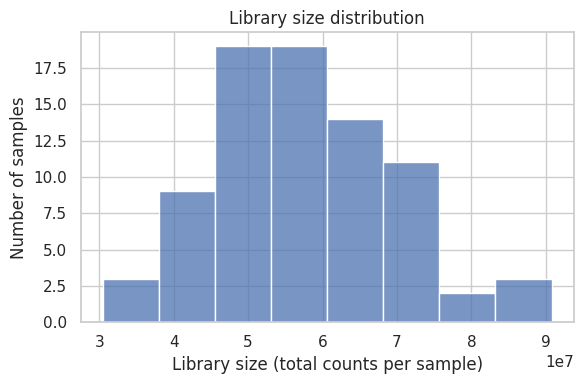

len(lib_sizes) = 80
len(meta)       = 80
NA in condition = 0


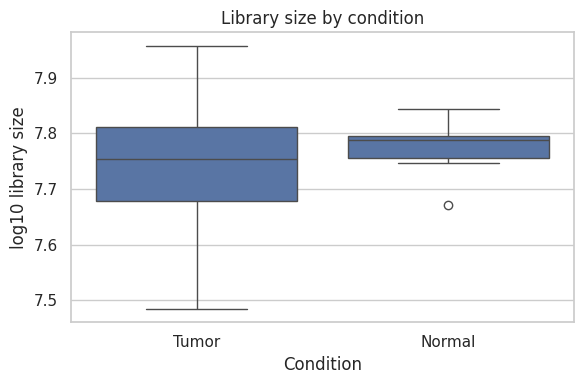

Filtered from 60616 to 26011 genes


In [ ]:
# ---------------------------
# library size distribution
# ---------------------------
lib_sizes = counts.sum(axis=0)
plt.figure(figsize=(6, 4))
sns.histplot(lib_sizes, kde=False)
plt.xlabel("Library size (total counts per sample)")
plt.ylabel("Number of samples")
plt.title("Library size distribution")
plt.tight_layout()
plt.show()

# ---- NEW BOXLOT BLOCK (replace your old boxplot code with this) ----
print("len(lib_sizes) =", len(lib_sizes))
print("len(meta)       =", len(meta))
print("NA in condition =", meta["condition"].isna().sum())

# Build a clean DataFrame for seaborn
plot_df = pd.DataFrame({
    "condition": meta["condition"].values,
    "log10_lib_size": np.log10(lib_sizes.values + 1),
})

plt.figure(figsize=(6, 4))
sns.boxplot(data=plot_df, x="condition", y="log10_lib_size")
plt.xlabel("Condition")
plt.ylabel("log10 library size")
plt.title("Library size by condition")
plt.tight_layout()
plt.show()
# --------------------------------------------------------------------

# ----------------------------------------
# Filter low-count genes (very important)
# Keep genes with at least MIN_COUNT in
# at least MIN_SAMPLES samples
# ----------------------------------------
MIN_COUNT = 10
MIN_SAMPLES = int(0.1 * counts.shape[1])  # present in at least 10% of samples

keep_mask = (counts >= MIN_COUNT).sum(axis=1) >= MIN_SAMPLES
counts_filt = counts.loc[keep_mask].copy()

print("Filtered from", counts.shape[0], "to", counts_filt.shape[0], "genes")

# Save filtered counts (optional)
counts_filt.to_csv("tcga_brca_star_counts_filtered.csv")

## Differential expression with PyDESeq2:

In [ ]:
# ============================================
# DESeq2 differential expression with PyDESeq2
# ============================================

# counts_filt: genes x samples -> transpose to samples x genes
dds_counts = counts_filt.T

# Build metadata with the condition factor aligned to dds_counts
clinical = pd.DataFrame(
    {
        "condition": meta.set_index("sample_submitter_id").loc[
            dds_counts.index, "condition"
        ]
    }
)

print("Condition counts in DE metadata:")
print(clinical["condition"].value_counts())

# Build DESeq2 dataset object
dds = DeseqDataSet(
    counts=dds_counts,
    metadata=clinical,
    design="~condition",     # single-factor design
)

# Run DESeq2
dds.deseq2()

# Tumor vs Normal contrast
stats = DeseqStats(
    dds,
    contrast=["condition", "Tumor", "Normal"],
)

stats.summary()

# Collect results
res_df = stats.results_df.copy()
print(res_df.head())

# Save full DE table
res_df.to_csv("tcga_brca_deseq2_results.csv")

Condition counts in DE metadata:
condition
Tumor     74
Normal     6
Name: count, dtype: int64
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.18 seconds.

Fitting dispersions...
... done in 52.02 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 58.22 seconds.

Fitting LFCs...
... done in 30.70 seconds.

Calculating cook's distance...
... done in 0.20 seconds.

Replacing 2005 outlier genes.

Fitting dispersions...
... done in 4.83 seconds.

Fitting MAP dispersions...
... done in 3.63 seconds.

Fitting LFCs...
... done in 3.11 seconds.

Running Wald tests...
... done in 7.97 seconds.



Log2 fold change & Wald test p-value: condition Tumor vs Normal
                    baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                            
ENSG00000000003  3067.813337       -0.630133  0.441925 -1.425881   
ENSG00000000005   121.134376       -4.506293  0.915297 -4.923315   
ENSG00000000419  2340.866669        0.347819  0.279107  1.246185   
ENSG00000000457  1555.539443        0.371088  0.269457  1.377173   
ENSG00000000460   652.404965        1.216055  0.336584  3.612927   
...                      ...             ...       ...       ...   
ENSG00000288658    17.389684        0.757146  0.797287  0.949653   
ENSG00000288663    28.243690        0.413498  0.364487  1.134465   
ENSG00000288670   421.289023       -0.427767  0.316998 -1.349431   
ENSG00000288674     7.571955       -1.005802  0.391863 -2.566718   
ENSG00000288675    37.134454        2.155856  0.460034  4.686291   

                       pvalue      padj  
gene_id  

### A. Volcano and MA plots:

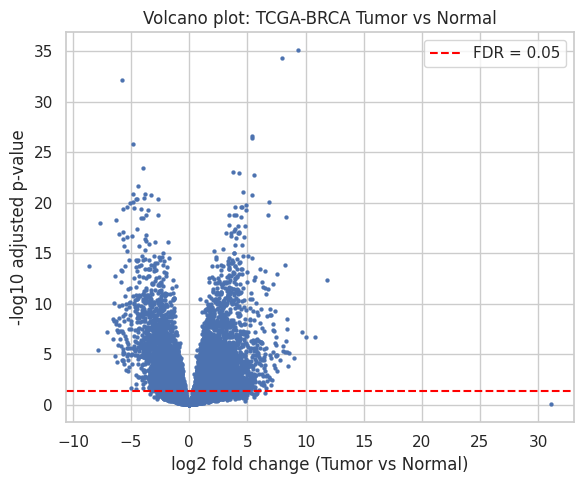

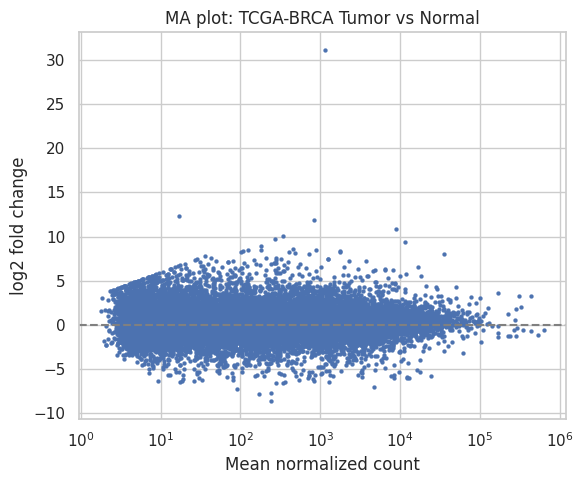

In [ ]:
# helper for -log10 padj
res_df["neg_log10_padj"] = -np.log10(res_df["padj"])

# Volcano
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=res_df,
    x="log2FoldChange",
    y="neg_log10_padj",
    s=8,
    edgecolor=None,
)
plt.axhline(-np.log10(0.05), color="red", linestyle="--", label="FDR = 0.05")
plt.xlabel("log2 fold change (Tumor vs Normal)")
plt.ylabel("-log10 adjusted p-value")
plt.title("Volcano plot: TCGA-BRCA Tumor vs Normal")
plt.legend()
plt.tight_layout()
plt.show()

# MA plot
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=res_df["baseMean"],
    y=res_df["log2FoldChange"],
    s=8,
    edgecolor=None,
)
plt.xscale("log")
plt.xlabel("Mean normalized count")
plt.ylabel("log2 fold change")
plt.title("MA plot: TCGA-BRCA Tumor vs Normal")
plt.axhline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()

## GSEA: Hallmark pathways (pre-ranked):

In [ ]:
# ===========================================
# Hallmark GSEA using Msigdb + Ensembl→symbol
# ===========================================

# install once per runtime (safe to leave here)
!pip install mygene

import mygene
from gseapy import Msigdb   # gseapy as gp is already imported above

# -------------------------------
# 1) Map Ensembl IDs to symbols
# -------------------------------

mg = mygene.MyGeneInfo()

# res_df comes from the PyDESeq2 step and has Ensembl IDs as index
# strip possible version suffixes like "ENSG000001234.5"
ensembl_ids = [g.split(".")[0] for g in res_df.index]

annot = mg.querymany(
    ensembl_ids,
    scopes="ensembl.gene",
    fields="symbol",
    species="human",
    as_dataframe=True,
    verbose=False,
)

# keep rows that have a symbol
mapping = annot[["symbol"]].dropna()
mapping.index.name = "ensembl"

# attach symbols back to DESeq2 results
res_df2 = res_df.copy()
res_df2["ensembl"] = [g.split(".")[0] for g in res_df2.index]

res_df2 = (
    res_df2
    .merge(mapping.reset_index(), how="left", on="ensembl")
    .dropna(subset=["symbol"])
)

# if multiple Ensembl IDs map to the same symbol, keep the one with
# the smallest adjusted p-value (most significant)
res_df2 = (
    res_df2
    .sort_values("padj")
    .drop_duplicates(subset=["symbol"], keep="first")
    .set_index("symbol")
)

print("Number of genes with mapped symbols:", res_df2.shape[0])

# -------------------------------
# 2) Build ranked list for GSEA
# -------------------------------
# use DESeq2 Wald statistic; you could swap to "log2FoldChange" if you prefer
ranked = (
    res_df2[["stat"]]
    .dropna()
    .sort_values("stat", ascending=False)
    .reset_index()
)
ranked.columns = ["gene", "score"]
print("Ranked table preview:")
print(ranked.head())

# -------------------------------
# 3) Get Hallmark gene sets (MSigDB)
# -------------------------------
msig = Msigdb()
print("Available MSigDB versions:", msig.list_dbver())

# choose a human version printed above, e.g. "2024.1.Hs"
HALLMARK_SETS = msig.get_gmt(
    category="h.all",     # Hallmark collection
    dbver="2024.1.Hs",    # change if needed to another Hs version
)

# -------------------------------
# 4) Run pre-ranked GSEA
# -------------------------------
pre_res = gp.prerank(
    rnk=ranked,
    gene_sets=HALLMARK_SETS,
    outdir="gsea_hallmark",   # results + plots written here
    min_size=10,
    max_size=5000,
    permutation_num=100,      # keep modest for Colab
    seed=0,
    format="png",
)

# 5) Main results table
gsea_results = pre_res.res2d.copy()
print("GSEA result columns:", gsea_results.columns)

# Prefer FDR q-val; fall back to NOM p-val if needed
if "FDR q-val" in gsea_results.columns:
    sort_col = "FDR q-val"
elif "NOM p-val" in gsea_results.columns:
    sort_col = "NOM p-val"
else:
    raise ValueError(
        f"No FDR / p-value-like column found in GSEA results: {list(gsea_results.columns)}"
    )

gsea_results = gsea_results.sort_values(sort_col)
gsea_results.to_csv("tcga_brca_gsea_hallmark_results.csv")
gsea_results.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.1 MB/s eta 0:00:00


Number of genes with mapped symbols: 22410
Ranked table preview:
       gene      score
0   COL10A1  13.281486
1     MMP11  13.087415
2      NEK2  11.599811
3    PKMYT1  11.550301
4  PAFAH1B3  10.813734


2025-11-27 04:52:29,592 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Available MSigDB versions:          Name     Last modified
0         6.0  2018-12-17 16:29
1         6.1  2018-12-17 16:29
2         6.2  2018-12-17 16:29
3         7.0  2020-01-27 04:43
4         7.1  2020-03-30 16:55
5         7.2  2020-09-18 23:33
6         7.3  2021-03-22 15:09
7         7.4  2021-04-02 14:38
8       7.5.1  2023-03-09 19:38
9         7.5  2022-01-13 01:00
10  2022.1.Hs  2023-03-09 19:37
11  2022.1.Mm  2023-03-09 19:37
12  2023.1.Hs  2023-08-19 15:08
13  2023.1.Mm  2023-08-19 15:09
14  2023.2.Hs  2023-10-21 01:29
15  2023.2.Mm  2023-10-20 08:32
16  2024.1.Hs  2024-09-03 14:38
17  2024.1.Mm  2024-09-03 14:38
18  2025.1.Hs  2025-06-08 14:03
19  2025.1.Mm  2025-06-08 14:03
GSEA result columns: Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,HALLMARK_E2F_TARGETS,0.679143,3.029843,0.0,0.0,0.0,110/200,16.23%,TK1;BIRC5;KIF4A;ASF1B;CENPM;SPC25;PLK1;RRM2;CD...
16,prerank,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.428503,1.730229,0.0,0.0,0.0,62/97,36.43%,IRF7;ISG15;CXCL10;CXCL11;OASL;PSME2;TRAFD1;ISG...
14,prerank,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.436562,1.812005,0.0,0.0,0.0,48/113,26.48%,H2AX;LSM4;MTHFD2;SLC7A5;EXOSC4;ARFGAP1;ALDH18A...
13,prerank,HALLMARK_MTORC1_SIGNALING,0.400746,1.831209,0.0,0.0,0.0,90/200,26.00%,PLK1;RRM2;BUB1;AURKA;TRIB3;SDF2L1;CCNF;SQLE;MT...
12,prerank,HALLMARK_MYOGENESIS,-0.376953,-1.879422,0.0,0.0,0.0,50/189,11.06%,MYOM1;SORBS1;PYGM;ACSL1;FHL1;GSN;CASQ2;DMD;MRA...


## ssGSEA to get pathway activity per sample (for ML features):

In [ ]:
# ================================
# ssGSEA: Hallmark pathway scores
# ================================
# requires:
#   counts_filt   (genes x samples, Ensembl IDs as index)
#   mapping       (index='ensembl', column 'symbol' from GSEA step)
#   HALLMARK_SETS (Hallmark dict from Msigdb)

# 1) Map Ensembl IDs in counts_filt to gene symbols
expr = counts_filt.copy()

# strip version suffix from Ensembl IDs (ENSG000001234.5 -> ENSG000001234)
expr.index = [g.split(".")[0] for g in expr.index]

# clean mapping table
map_sym = mapping.copy()              # index = ensembl
map_sym = map_sym[~map_sym["symbol"].isna()]
map_sym.index = map_sym.index.astype(str)

# IMPORTANT: one row per Ensembl ID
map_sym = map_sym[~map_sym.index.duplicated(keep="first")]

# keep only genes that have a symbol mapping
common = expr.index.intersection(map_sym.index)
print("Genes in expression:", expr.shape[0])
print("Genes with symbol mapping (unique):", len(common))

expr = expr.loc[common]
expr.index = map_sym.loc[common, "symbol"].values

# collapse duplicate symbols by averaging
expr = expr.groupby(expr.index).mean()
print("Expression matrix for ssGSEA (genes x samples):", expr.shape)

# 2) log1p-transform for stability
expr_for_ssgsea = np.log1p(expr)

# 3) Run ssGSEA using Hallmark gene sets from Msigdb
ss = gp.ssgsea(
    data=expr_for_ssgsea,      # genes (symbols) x samples
    gene_sets=HALLMARK_SETS,   # dict from Msigdb.get_gmt(...)
    outdir="ssgsea_hallmark",
    sample_norm_method="rank",
    min_size=10,
    max_size=5000,
    no_plot=True,
    processes=4,
)

# 4) Extract scores: pathways x samples
pathway_scores = ss.res2d
print("Pathway scores shape (pathways x samples):", pathway_scores.shape)

# Transpose to samples x pathways for ML
X_pathways = pathway_scores.T
X_pathways.head()

Genes in expression: 26011
Genes with symbol mapping (unique): 22434
Expression matrix for ssGSEA (genes x samples): (22398, 80)


/tmp/ipython-input-3483279862.py:39: DeprecationWarning: processes is deprecated; use threads
  ss = gp.ssgsea(


Pathway scores shape (pathways x samples): (4000, 4)


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
Name,TCGA-E9-A22G-01A,TCGA-BH-A1FC-01A,TCGA-AO-A12F-01A,TCGA-AR-A1AQ-01A,TCGA-C8-A134-01A,TCGA-AC-A2BK-01A,TCGA-AO-A129-01A,TCGA-BH-A5IZ-01A,TCGA-A2-A0CY-01A,TCGA-A2-A3XS-01A,...,TCGA-BH-A0HK-01A,TCGA-GM-A2D9-01A,TCGA-A2-A3XS-01A,TCGA-BH-A0B7-11A,TCGA-BH-A1F0-11B,TCGA-BH-A0HX-01A,TCGA-BH-A5IZ-01A,TCGA-GM-A3XG-01A,TCGA-E9-A5FL-01A,TCGA-AO-A03T-01A
Term,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,...,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN
ES,9340.74235,9252.38775,9137.747448,8997.039201,8987.973671,8984.153335,8976.383549,8909.780853,8844.868861,8839.898042,...,-248.068273,-237.670058,-180.941922,-173.843237,-167.946235,-139.277135,73.111518,-36.072697,35.959698,26.481043
NES,0.881019,0.872685,0.861872,0.848601,0.847746,0.847385,0.846652,0.84037,0.834248,0.833779,...,-0.023398,-0.022417,-0.017066,-0.016397,-0.015841,-0.013137,0.006896,-0.003402,0.003392,0.002498


## ML classifiers (logistic regression + RF):
We’ll build two feature sets:

* Gene features: top N DE genes by FDR (global ranking – simple version).

* Pathway features: ssGSEA Hallmark scores.

Then evaluate logistic regression and random forest with stratified 5-fold CV.

### A. Prepare features:

In [ ]:
# ============================================
# A. Prepare features (genes + pathways + y)
# ============================================

TOP_N_GENES = 100

# ----------------------------------------------------
# 0) Rebuild labels so that indices match sample IDs
#    in counts_filt / X_genes / X_pathways
# ----------------------------------------------------
# meta should still have a column 'sample_submitter_id'
# and a column 'sample_type' (Primary Tumor / Solid Tissue Normal)

meta_lbl = meta.set_index("sample_submitter_id")

# Use the same samples (columns) as in counts_filt
sample_ids = counts_filt.columns.astype(str)

y = meta_lbl.loc[sample_ids, "sample_type"].map(
    {"Solid Tissue Normal": 0, "Primary Tumor": 1}
)

# Drop any samples that didn’t map cleanly
y = y.dropna().astype(int)
print("Label counts:\n", y.value_counts())

# ----------------------------------------------------
# 1) Top-N DE genes (global ranking) → X_genes
# ----------------------------------------------------
de_sorted = (
    res_df
    .dropna(subset=["padj"])
    .sort_values("padj")
)

top_genes = de_sorted.index[:TOP_N_GENES]
print("Top genes:", len(top_genes))

# counts_filt: genes x samples → log1p + transpose → samples x genes
X_genes = np.log1p(counts_filt.loc[top_genes]).T
print("X_genes initial shape (samples x genes):", X_genes.shape)

# ----------------------------------------------------
# 2) Pathway features from Hallmark sets → X_pathways
# ----------------------------------------------------
# expr_for_ssgsea: genes (symbols) x samples, same samples as counts_filt
expr_log = np.log1p(expr_for_ssgsea)

pathway_means = {}
MIN_GENES_PER_SET = 10  # require at least this many genes per pathway

for set_name, genes in HALLMARK_SETS.items():
    genes_in_expr = expr_log.index.intersection(genes)
    if len(genes_in_expr) < MIN_GENES_PER_SET:
        continue  # skip tiny pathways

    # mean log expression across genes in the set for each sample
    pathway_means[set_name] = expr_log.loc[genes_in_expr].mean(axis=0)

# samples x pathways
X_pathways = pd.DataFrame(pathway_means)
print("X_pathways raw shape (samples x pathways):", X_pathways.shape)

# ----------------------------------------------------
# 3) Align samples across y, X_genes, X_pathways
# ----------------------------------------------------
common_samples = (
    y.index
    .intersection(X_genes.index)
    .intersection(X_pathways.index)
)

print("Number of common samples across y, X_genes, X_pathways:", len(common_samples))

X_genes = X_genes.loc[common_samples]
X_pathways = X_pathways.loc[common_samples]
y = y.loc[common_samples]

print("Final shapes after alignment:")
print("  X_genes    :", X_genes.shape)
print("  X_pathways :", X_pathways.shape)
print("  y          :", y.shape)

display(X_genes.head())
display(X_pathways.head())
print("Final label counts:\n", y.value_counts())

Label counts:
 sample_type
1    74
0     6
Name: count, dtype: int64
Top genes: 100
X_genes initial shape (samples x genes): (80, 100)
X_pathways raw shape (samples x pathways): (80, 50)
Number of common samples across y, X_genes, X_pathways: 80
Final shapes after alignment:
  X_genes    : (80, 100)
  X_pathways : (80, 50)
  y          : (80,)


gene_id,ENSG00000123500,ENSG00000099953,ENSG00000119927,ENSG00000117650,ENSG00000127564,ENSG00000101605,ENSG00000079308,ENSG00000079462,ENSG00000167900,ENSG00000175063,...,ENSG00000188322,ENSG00000119333,ENSG00000131016,ENSG00000169607,ENSG00000255471,ENSG00000077152,ENSG00000168477,ENSG00000174804,ENSG00000165410,ENSG00000076555
TCGA-E2-A15L-01A,10.773336,11.360683,7.291656,7.772753,6.658011,4.127134,9.593628,8.161375,8.305237,7.407318,...,7.539559,8.401109,8.453827,6.529419,4.510860,7.282761,5.497168,8.184235,6.927558,6.910751
TCGA-5L-AAT0-01A,9.516132,10.932375,6.584791,5.384495,5.225747,4.744932,8.610137,7.473069,6.860664,5.796058,...,7.005789,8.085487,7.557473,4.510860,3.931826,5.991465,5.771441,7.768956,6.280396,6.710523
TCGA-E9-A1NF-01A,10.695733,11.723138,6.033086,5.780744,6.373320,5.627621,8.573763,6.885510,7.307202,7.433667,...,5.902633,7.952615,7.553287,5.676754,3.332205,6.569481,5.746203,6.966024,6.747587,6.222576
TCGA-A7-A0CD-01A,8.874168,9.953800,7.563201,7.170888,6.770789,5.198497,9.205529,7.915713,8.536407,7.022868,...,7.704361,8.385032,7.469654,6.259581,3.496508,6.735780,7.004882,7.738924,7.563201,8.087640
TCGA-EW-A3E8-01B,9.109193,10.437492,8.719644,6.272877,7.150701,5.631212,9.505023,7.945201,8.015658,7.163172,...,7.679714,9.476084,8.102889,5.517453,4.804021,6.682109,7.804251,8.430763,6.983790,8.462737


,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
TCGA-E2-A15L-01A,2.157618,1.854134,2.192360,2.177535,2.004173,1.951019,2.140717,1.892186,2.124048,1.960287,...,2.231909,2.171071,1.684267,2.205379,2.069636,2.209034,2.188490,2.062994,1.995540,1.947877
TCGA-5L-AAT0-01A,2.079313,1.941889,2.125452,2.135683,1.995259,1.933263,2.099175,1.872745,2.055274,1.964049,...,2.147037,2.110037,1.667923,2.155279,2.015342,2.128270,2.106858,2.002603,2.001522,1.889125
TCGA-E9-A1NF-01A,2.097443,1.920053,2.119556,2.175087,1.972626,1.909498,2.111774,1.861099,2.042145,1.991585,...,2.165938,2.147769,1.625520,2.159078,2.032733,2.155717,2.128469,2.031373,1.944322,1.918951
TCGA-A7-A0CD-01A,2.173776,1.873211,2.176227,2.128225,1.998984,1.949812,2.129927,1.927238,2.124705,1.925397,...,2.251593,2.147977,1.744541,2.205778,2.038123,2.201119,2.175217,2.070687,2.007566,1.934434
TCGA-EW-A3E8-01B,2.218485,2.078536,2.204928,2.218274,2.092574,2.033214,2.189943,1.989430,2.190198,2.066428,...,2.225596,2.216324,1.802228,2.228037,2.153779,2.224937,2.192852,2.136963,2.077139,2.032609


Final label counts:
 sample_type
1    74
0     6
Name: count, dtype: int64


### B. Helper for cross-validated evaluation:

In [ ]:
def cv_evaluate(X, y, model_type="logreg", n_splits=5, random_state=0):
    """
    Cross-validated evaluation for binary Tumor vs Normal classification.

    X: DataFrame (samples x features)
    y: Series of 0/1 labels
    """
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    metrics = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale features (fit on train, transform train + test)
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        if model_type == "logreg":
            clf = LogisticRegression(
                max_iter=1000,
                penalty="l2",
                solver="liblinear",
            )
        elif model_type == "rf":
            clf = RandomForestClassifier(
                n_estimators=500,
                max_depth=None,
                min_samples_leaf=2,
                random_state=random_state,
                n_jobs=-1,
            )
        else:
            raise ValueError("model_type must be 'logreg' or 'rf'")

        clf.fit(X_train_s, y_train)
        y_proba = clf.predict_proba(X_test_s)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        fold_metrics = {
            "fold": fold,
            "roc_auc": roc_auc_score(y_test, y_proba),
            "pr_auc": average_precision_score(y_test, y_proba),
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
        }
        metrics.append(fold_metrics)
        print(
            f"Fold {fold} – ROC-AUC: {fold_metrics['roc_auc']:.3f}, "
            f"PR-AUC: {fold_metrics['pr_auc']:.3f}, "
            f"Acc: {fold_metrics['accuracy']:.3f}, "
            f"F1: {fold_metrics['f1']:.3f}"
        )

    metrics_df = pd.DataFrame(metrics)
    print("\nMean CV metrics:")
    print(metrics_df.mean(numeric_only=True))
    return metrics_df

### C. Run models:

In [ ]:
print("=== Logistic regression with top DE genes ===")
metrics_genes_logreg = cv_evaluate(X_genes, y, model_type="logreg")

print("\n=== Random forest with top DE genes ===")
metrics_genes_rf = cv_evaluate(X_genes, y, model_type="rf")

print("\n=== Logistic regression with pathway scores ===")
metrics_path_logreg = cv_evaluate(X_pathways, y, model_type="logreg")

print("\n=== Random forest with pathway scores ===")
metrics_path_rf = cv_evaluate(X_pathways, y, model_type="rf")

metrics_genes_logreg.to_csv("metrics_genes_logreg.csv", index=False)
metrics_genes_rf.to_csv("metrics_genes_rf.csv", index=False)
metrics_path_logreg.to_csv("metrics_path_logreg.csv", index=False)
metrics_path_rf.to_csv("metrics_path_rf.csv", index=False)

=== Logistic regression with top DE genes ===
Fold 1 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 2 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 3 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 4 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 0.938, F1: 0.966
Fold 5 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000

Mean CV metrics:
fold        3.000000
roc_auc     1.000000
pr_auc      1.000000
accuracy    0.987500
f1          0.993103
dtype: float64

=== Random forest with top DE genes ===
Fold 1 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 2 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 3 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 4 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 1.000, F1: 1.000
Fold 5 – ROC-AUC: 1.000, PR-AUC: 1.000, Acc: 0.938, F1: 0.966

Mean CV metrics:
fold        3.000000
roc_auc     1.000000
pr_auc      1.000000
accuracy    0.987500
f1          0.993103
dtype: float64

=== Logistic reg

In [ ]:
# ============================================================
# Final summary: CV metrics + feature interpretation
# (place this cell AFTER the "Run models" section)
# ============================================================

import pandas as pd
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------------
# 1) Summarize CV metrics for all models
#    (assumes metrics_* DataFrames exist from the previous cell)
# ------------------------------------------------------------

def mean_metrics(df, label):
    """Return a dict with mean CV metrics for one model."""
    return {
        "model": label,
        "roc_auc": df["roc_auc"].mean(),
        "pr_auc": df["pr_auc"].mean(),
        "accuracy": df["accuracy"].mean(),
        "f1": df["f1"].mean(),
    }

summary_rows = [
    mean_metrics(metrics_genes_logreg, "genes_logreg"),
    mean_metrics(metrics_genes_rf,     "genes_rf"),
    mean_metrics(metrics_path_logreg,  "pathways_logreg"),
    mean_metrics(metrics_path_rf,      "pathways_rf"),
]

metrics_summary = pd.DataFrame(summary_rows)
print("=== Summary of mean cross-validated metrics ===")
display(metrics_summary)

metrics_summary.to_csv("metrics_summary_all_models.csv", index=False)

# ------------------------------------------------------------
# 2) Fit final logistic-regression models on full data
#    and extract top features
# ------------------------------------------------------------

# Helper: choose DESeq2 result table if available, otherwise empty
try:
    _res_df_for_annot = res_df  # DESeq2 results table
except NameError:
    _res_df_for_annot = pd.DataFrame(index=X_genes.columns)

def annotate_with_de(coef_series, res_df):
    """
    Turn a coefficient Series into a DataFrame and, if possible,
    join DESeq2 info (symbol, log2FC, padj, baseMean).
    """
    df = coef_series.to_frame(name="coef").reset_index().rename(columns={"index": "gene_id"})
    annot_cols = [c for c in ["symbol", "log2FoldChange", "padj", "baseMean"] if c in res_df.columns]
    if annot_cols:
        df = df.merge(res_df[annot_cols], left_on="gene_id", right_index=True, how="left")
    return df

# --------------------------
# 2A) Gene-level model
# --------------------------

pipe_genes_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, penalty="l2", solver="liblinear"),
)
pipe_genes_lr.fit(X_genes, y)

lr_genes = pipe_genes_lr.named_steps["logisticregression"]
coef_genes = pd.Series(lr_genes.coef_[0], index=X_genes.columns)

# Positive coefficients -> more associated with Tumor
top_genes_pos = coef_genes.sort_values(ascending=False).head(20)
# Negative coefficients -> more associated with Normal
top_genes_neg = coef_genes.sort_values(ascending=True).head(20)

genes_pos_df = annotate_with_de(top_genes_pos, _res_df_for_annot)
genes_neg_df = annotate_with_de(top_genes_neg, _res_df_for_annot)

print("\n=== Top 20 genes with positive coefficients (Tumor-associated) ===")
display(genes_pos_df)

print("\n=== Top 20 genes with negative coefficients (Normal-associated) ===")
display(genes_neg_df)

genes_pos_df.to_csv("logreg_top_genes_positive.csv", index=False)
genes_neg_df.to_csv("logreg_top_genes_negative.csv", index=False)

# --------------------------
# 2B) Pathway-level model
# --------------------------

pipe_path_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, penalty="l2", solver="liblinear"),
)
pipe_path_lr.fit(X_pathways, y)

lr_paths = pipe_path_lr.named_steps["logisticregression"]
coef_paths = pd.Series(lr_paths.coef_[0], index=X_pathways.columns)

top_paths_pos = (
    coef_paths.sort_values(ascending=False)
    .head(20)
    .to_frame(name="coef")
    .reset_index()
    .rename(columns={"index": "pathway"})
)

top_paths_neg = (
    coef_paths.sort_values(ascending=True)
    .head(20)
    .to_frame(name="coef")
    .reset_index()
    .rename(columns={"index": "pathway"})
)

print("\n=== Top 20 pathways with positive coefficients (Tumor-associated) ===")
display(top_paths_pos)

print("\n=== Top 20 pathways with negative coefficients (Normal-associated) ===")
display(top_paths_neg)

top_paths_pos.to_csv("logreg_top_pathways_positive.csv", index=False)
top_paths_neg.to_csv("logreg_top_pathways_negative.csv", index=False)

=== Summary of mean cross-validated metrics ===


,model,roc_auc,pr_auc,accuracy,f1
0,genes_logreg,1.000000,1.000000,0.9875,0.993103
1,genes_rf,1.000000,1.000000,0.9875,0.993103
2,pathways_logreg,1.000000,1.000000,1.0000,1.000000
3,pathways_rf,0.979524,0.998214,0.9375,0.967312



=== Top 20 genes with positive coefficients (Tumor-associated) ===


,gene_id,coef,log2FoldChange,padj,baseMean
0,ENSG00000103253,0.371770,4.513437,2.905962e-20,684.182425
1,ENSG00000230838,0.297879,6.801097,1.873308e-19,347.669975
2,ENSG00000123500,0.256317,9.368751,7.665395e-36,11536.977363
3,ENSG00000152253,0.214304,3.431611,1.527149e-18,403.659958
4,ENSG00000183010,0.188374,3.401033,1.751077e-19,4234.663599
5,ENSG00000188322,0.185614,3.422798,3.352332e-15,2431.340092
6,ENSG00000135127,0.167428,3.964497,2.554328e-20,1654.280752
7,ENSG00000175445,0.160837,-6.046571,1.262374e-17,12832.035094
8,ENSG00000100162,0.154356,3.987348,1.848300e-19,501.431687
9,ENSG00000276043,0.149105,4.585638,8.369172e-22,1315.360318



=== Top 20 genes with negative coefficients (Normal-associated) ===


,gene_id,coef,log2FoldChange,padj,baseMean
0,ENSG00000226009,-0.466125,-4.421493,2.015728e-22,10.926769
1,ENSG00000186205,-0.249362,-3.823482,4.492449e-16,1233.571660
2,ENSG00000165410,-0.232332,-2.493828,5.242731e-15,1311.179232
3,ENSG00000115459,-0.232230,-2.228856,9.988983e-16,1700.667203
4,ENSG00000091436,-0.186291,-2.308855,2.271759e-15,4617.667600
5,ENSG00000165084,-0.178584,-4.802826,1.396539e-21,61.326775
6,ENSG00000133800,-0.165448,-5.706785,7.764303e-18,854.133520
7,ENSG00000205726,-0.164610,-2.645191,3.897187e-21,3406.898202
8,ENSG00000108960,-0.163501,-3.751479,5.640410e-17,2142.550790
9,ENSG00000077616,-0.142416,-3.854256,3.248462e-21,115.487379



=== Top 20 pathways with positive coefficients (Tumor-associated) ===


,pathway,coef
0,HALLMARK_COAGULATION,0.408589
1,HALLMARK_GLYCOLYSIS,0.389126
2,HALLMARK_ESTROGEN_RESPONSE_LATE,0.352641
3,HALLMARK_G2M_CHECKPOINT,0.321533
4,HALLMARK_E2F_TARGETS,0.317271
5,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.317058
6,HALLMARK_DNA_REPAIR,0.302180
7,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.292729
8,HALLMARK_MTORC1_SIGNALING,0.215396
9,HALLMARK_ANGIOGENESIS,0.200295



=== Top 20 pathways with negative coefficients (Normal-associated) ===


,pathway,coef
0,HALLMARK_UV_RESPONSE_DN,-0.525615
1,HALLMARK_WNT_BETA_CATENIN_SIGNALING,-0.521053
2,HALLMARK_PROTEIN_SECRETION,-0.354179
3,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.283182
4,HALLMARK_ADIPOGENESIS,-0.273901
5,HALLMARK_HYPOXIA,-0.242032
6,HALLMARK_FATTY_ACID_METABOLISM,-0.229877
7,HALLMARK_BILE_ACID_METABOLISM,-0.191095
8,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,-0.170039
9,HALLMARK_HEDGEHOG_SIGNALING,-0.158366
